In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial as Poly

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
customer_df = pd.read_csv("csv/mall_customers.csv")

In [3]:
customer_df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


# Data Cleaning

In [4]:
def remove_null(df):
    """
        This function takes our dataframe, 
        drops the rows with unavailable values 
        (nans) and returns the dataframe
    """
    
    for i, row in df.iterrows():
        if row.isna().any():
            df = df.dropna()

    return df

In [5]:
def rename_columns(df):
    """
        This function renames and re-orders 
        the columns in our dataframe for 
        easier indexing and creates new 
        rows by column operations
    """
    
    labels = ["10 - 19", "20 - 29", "30 - 39", 
              "40 - 49", "50 - 59", "60 - 69", "70+"]

    ranges = [10, 19, 29, 39, 49, 59, 69, np.inf]

    gender_dict = {"Male": 1, "Female": 2}

    df["gender_class"] = df["Gender"].replace(gender_dict)

    df["gender_class"] = df["gender_class"].astype("category")

    df["Age_group"] = pd.cut(customer_df["Age"], 
                             bins = ranges, 
                             labels = labels
                             )

    df["Annual Income (k$)"] = df["Annual Income (k$)"] * 1000

    df["total_amount"] = ((df["Annual Income (k$)"]) 
                          * (df["Spending Score (1-100)"] / 100))

    new_order = ['CustomerID', 'Age', 'Annual Income (k$)', 
                 'Spending Score (1-100)', 'total_amount', 
                 'gender_class', 'Gender', 'Age_group']

    df = df[new_order]

    new_column_names = {'CustomerID': 'customer_id', 'Age': 'age', 
                        'Annual Income (k$)': 'annual_income', 
                        'Spending Score (1-100)': 'spending_score', 
                        'Gender': 'gender', 'Age_group': 'age_group'}

    df = df.rename(columns = new_column_names)

    return df

In [6]:
def remove_duplicates(df):
    """
        This function drops duplicate 
        data in our dataframe
    """
    
    newdf = df.drop_duplicates(subset = ["age", 
                                         "gender", 
                                         "spending_score"], 
                               keep = "first")

    newdf = newdf.drop_duplicates(subset = ["age", 
                                            "gender", 
                                            "annual_income"],
                                  keep = "last")

    return newdf

In [7]:
def remove_outliers(df):
    """
        This function querys out dataframe and 
        select only the data that has no outliers
    """
    newdf = df.query("spending_score > 9 & annual_income < 70000")
    newdf = newdf.drop([123]) # A manually detected outlier.

    return newdf

In [8]:
def cleanse(df):
    no_null_df = remove_null(df)
    renamed_df = rename_columns(no_null_df)
    unique_df = remove_duplicates(renamed_df)
    clean_df = remove_outliers(unique_df)
    return clean_df

In [9]:
def plot_sized_scatter(df, xdata, ydata):
    plt.figure(dpi = 100)

    sns.scatterplot(
        data = df, x = xdata, y = ydata, hue = "gender",
        size = "age_group", zorder = 2, sizes=(100, 20), alpha = 0.7
    )

    plt.grid(zorder = 0, alpha = 0.3)

    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.02))

    plt.title("Customer Ids by their Spending Score")

    plt.savefig("CustomerId_vs_Spending_Score")

    plt.show()

In [165]:
def plot_scatter(df, xdata, ydata, ymin, ymax, xlabel, ylabel, title):
    plt.figure(dpi = 100)

    sns.scatterplot(
        data = df, x = xdata, y = ydata,
        zorder = 2, alpha = 0.7, label = "data"
    )

    plt.grid(zorder = 0, alpha = 0.3)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.ylim(ymin, ymax)

    plt.legend(loc = 'upper right')

    plt.title(title)

    plt.savefig(title)

    plt.show()

In [146]:
def plot_age_hist(df, labels):

    plt.figure(dpi = 100)

    plt.grid(zorder = 0, alpha = 0.3)

    plt.hist(df["age_group"], zorder = 2, 
             bins = len(labels), alpha = 0.85, 
             edgecolor = "white")

    plt.xlabel("Age Intervals")
    plt.ylabel("Frequency")

    plt.title("Distribution of Age Groups")

    plt.xticks(rotation = 45)

    plt.savefig("age_dist")

    plt.show()

In [56]:
# Bar plot of customers by their gender 
def plot_barplot():
    """
        Makes a barplot of 
        the gender distribution
    """
    plt.figure(figsize = (10, 7))

    gender = cdf["gender"].unique()
    count = [len(cdf[cdf["gender"] == "Male"]), 
             len(cdf[cdf["gender"] == "Female"])]
    bar_colors = ['tab:red', 'tab:blue']

    plt.bar(gender, count, label = gender, color = bar_colors)

    plt.xlabel("Gender", fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)

    plt.title("Distribution by Gender", fontsize = 18)

    plt.xticks(fontsize = 14)
    plt.yticks(np.linspace(0, 80, 9), fontsize = 14)

    plt.legend(fontsize = 12)

    plt.savefig("gender_dist")

    plt.show()

In [119]:
def plot_3d_scatter():
    """
        Makes a scatter plot with 3 axes
        Age, Annual Income and Spending score 
    """    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(cdf["age"], cdf["annual_income"], 
               cdf["spending_score"], marker = "o")

    plt.title("3D Plot of Age, Income and Spending Score")

    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income')
    ax.set_zlabel('Spending Score')

    plt.savefig("3d_plot_for_age_income_spending")

    plt.show()

In [33]:
def plot_heatmap(corr_matrix):
    """
        Plots the correlation matrix between numerical variables
    """
    sns.heatmap(corr_matrix, 
                cmap = sns.cubehelix_palette(as_cmap = True), 
                vmin = -0.4, vmax = 1, annot = True, fmt = ".3f")

    plt.xticks(rotation = 45)

    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.title("CORRELATION MATRIX", fontsize = 18)

    plt.savefig("correlation_martrix")

    plt.show()

In [46]:
# Pairplot
def plot_pairplot():
    """
        Plots the scatter and histogram relationship between all variables
    """
    g = sns.PairGrid(gen_fig, hue = 'gender')
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)

    g.figure.suptitle("Age,, Income, Spending Score, and Total Amount Spent Pairgrid", size = 20)
    plt.subplots_adjust(top = 0.93)
    g.add_legend()

    plt.savefig("pairgrid")

    plt.show()

In [149]:
# Let's start model fitting on annual income vs total spending

def linfunc(x, a, b):
    """ Function for fitting a straight line, for curve_fit
        x: independent variable
        a, b: parameters to be fitted
    """
    y = (a * x) + b
    return y

In [155]:
def fitting():
    """
        Function that performs the fitting
    """
    inc = cdf["annual_income"]
    spending = cdf["total_amount"]

    p, cov = curve_fit(linfunc, inc, spending)

    sigma = np.sqrt(np.diag(cov))

    print(f"a = {p[0]:.2f} +/- {sigma[0]:.2f}")
    print(f"b = {p[1]:.2f} +/- {sigma[1]:.2f}\n\n")

    p_np = Poly.fit(inc, spending, 1)
    cov = np.polyfit(inc, spending, 1, cov = True)[1]
    sigma_np = np.sqrt(np.diag(cov))

    b, a = p_np.convert().coef
    print(f"a = {a:.2f} +/- {sigma_np[0]:.2f}")
    print(f"b = {b:.2f} +/- {sigma_np[1]:.2f}")

    return inc, spending, p, sigma

In [161]:
def plot_fit():
    """
        Plots the scatter with the fitting function
    """
    plt.figure(dpi = 100)

    sns.scatterplot(
        data = cdf, x = inc, y = spending, hue = "age_group",
        sizes=(20, 200), alpha = 0.7
    )

    xfit = np.linspace(np.min(inc), np.max(inc), 100)
    plt.plot(xfit, linfunc(xfit, p[0], p[1]), 'r-', label = "Fitted Line")

    plt.xlabel("Customer Income")
    plt.ylabel("Total Amount")

    # plt.ylim(0, 80)
    plt.fill_between(xfit, linfunc(xfit, p[0] - sigma[0], p[1] - sigma[1]),
                        linfunc(xfit, p[0] + sigma[0], p[1] + sigma[1]), 
                        color = 'k', alpha = 0.1, label = "Error Margin")

    plt.legend(loc='upper right', bbox_to_anchor=(1.31, 1.02))

    plt.title("Plot of Customer's Annual Income by their Total Amount Spent")

    plt.grid(zorder = 0, alpha = 0.3)

    plt.savefig("total_amount_income_fit")

    plt.show()

In [83]:
def plot_boxplots():
    """
        Plots boxplots of distributions to detect outliers
    """
    fig, ax = plt.subplots(2, 2, figsize = (12, 12))
    ax = ax.flatten()

    sns.boxplot(y = "age", palette = ["c"], data = cdf, ax = ax[0])
    sns.boxplot(y = "spending_score", palette = ["m"], data = cdf, ax = ax[1])
    sns.boxplot(y = "annual_income", palette = ["g"], data = cdf, ax = ax[2])
    sns.boxplot(y = "total_amount", palette = ["y"], data = cdf, ax = ax[3])

    ax[0].set_title("Age", fontsize = 14)
    ax[1].set_title("Spending Score", fontsize = 14)
    ax[2].set_title("Annual Income", fontsize = 14)
    ax[3].set_title("Total Amount Spent", fontsize = 14)

    fig.suptitle("Boxplot for Age, Spending Score, Annual Income and Total Amount spent", fontsize = 18)

    plt.savefig("age_score_total_boxplot")

    plt.show()

In [167]:
def create_clusters(x, y):
    """
        Function that segments clusters 
        into the nclusters variables 
        and creates clusters centers
    """
    xy = np.column_stack((x, y))

    ncluster = 5

    kmeans = KMeans(n_clusters = ncluster, n_init = 200)

    kmeans.fit(xy) 

    labels = kmeans.labels_  
    
    cen = kmeans.cluster_centers_
    xkmeans = cen[:, 0]
    ykmeans = cen[:, 1]

    return xy, xkmeans, ykmeans, labels


In [137]:
def plot_fitted_clusters(x, y, xkmeans, ykmeans, labels):
    """
    Plots clustered data as a scatter plot with determined centres shown
    """
    fig, ax = plt.subplots(dpi = 144)
    
    # Plot data points with different colors based on their cluster labels
    s = ax.scatter(x, y, c = labels, s = 10, 
                   cmap = 'Set1', marker = 'o', 
                   label = 'Data')

    # Plot the estimated cluster centers
    ax.plot(xkmeans, ykmeans, 'k+', ms = 10, label = 'Estimated Centres')

    # Add colorbar to show the mapping of cluster labels to colors
    cbar = fig.colorbar(s, ax = ax)
    cbar.set_ticks(np.unique(labels))
    
    ax.set_ylim(0, 170)

    plt.grid(zorder = 0, alpha = 0.3)

    ax.legend()
    ax.set_xlabel('Spending Score')
    ax.set_ylabel('Annual Income (in $000)')

    plt.title("Cluster Plot For Spending Score Against Annual Income")

    plt.savefig("clustering")
    
    plt.show()

In [109]:
def one_silhoutte(n, xy):
    """ 
    Calculates the silhoutte score for n clusters 
    """
    # set up the clusterer with the number of expected clusters
    kmeans = KMeans(n_clusters = n, n_init = 20)
    # Fit the data
    kmeans.fit(xy)
    labels = kmeans.labels_
    
    # calculate the silhoutte score
    score = silhouette_score(xy, labels)

    return score

In [136]:
def plot_elbow_method(min_k, max_k, wcss, best_n):
    """
    Plots the elbow method between min_k and max_k
    """
    fig, ax = plt.subplots(dpi = 144)
    ax.plot(range(min_k, max_k + 1), wcss, 'kx-')
    ax.scatter(best_n, wcss[best_n - min_k], 
               marker = 'o', color = 'red', 
               facecolors = 'none', s = 50)
    ax.set_xlabel('k')
    ax.set_xlim(min_k, max_k)
    ax.set_ylabel('WCSS')

    plt.grid(zorder = 0, alpha = 0.3)

    plt.title("Elbow Score", fontsize = 18)

    plt.savefig("elbow plot")

    plt.show()
    return

In [14]:
cdf = customer_df.copy()
cdf = cleanse(cdf)

In [15]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 0 to 122
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     116 non-null    int64   
 1   age             116 non-null    int64   
 2   annual_income   116 non-null    int64   
 3   spending_score  116 non-null    int64   
 4   total_amount    116 non-null    float64 
 5   gender_class    116 non-null    category
 6   gender          116 non-null    object  
 7   age_group       116 non-null    category
dtypes: category(2), float64(1), int64(4), object(1)
memory usage: 7.0+ KB


In [16]:
cdf.describe(include = "category")

,gender_class,age_group
count,116,116
unique,2,7
top,2,20 - 29
freq,69,29


In [17]:
cdf.describe(include = "int")

,customer_id,age,annual_income,spending_score
count,116.000000,116.000000,116.000000,116.000000
mean,64.198276,39.844828,45172.413793,52.172414
std,35.107591,16.065412,15721.641613,17.304574
min,1.000000,18.000000,15000.000000,13.000000
25%,35.750000,24.000000,33000.000000,42.000000
50%,64.500000,38.000000,47500.000000,50.500000
75%,94.250000,50.250000,60000.000000,59.000000
max,123.000000,70.000000,69000.000000,99.000000


In [18]:
age_skew = ss.skew(cdf["age"])
income_skew = ss.skew(cdf["annual_income"])
score_skew = ss.skew(cdf["spending_score"])

In [19]:
age_kurt = ss.kurtosis(cdf["age"])
income_kurt = ss.kurtosis(cdf["annual_income"])
score_kurt = ss.kurtosis(cdf["spending_score"])

In [24]:
print(f"The average age is: {cdf['age'].mean()}")
print(f"The standard deviation for age is: {cdf['age'].std()}")
print(f"The skewness of the age distribution is: {age_skew}")
print(f"The Kurtosis of the age distribution is: {age_kurt}")

The average age is: 39.8448275862069
The standard deviation for age is: 16.06541164347689
The skewness of the age distribution is: 0.31106877473884875
The Kurtosis of the age distribution is: -1.1336215058057897


In [26]:
print(f"The average income is: {cdf['annual_income'].mean()}")
print(f"The standard deviation for income is: {cdf['annual_income'].std()}")
print(f"The skewness of the income distribution is: {income_skew}")
print(f"The Kurtosis of the income distribution is: {income_kurt}")

The average income is: 45172.41379310345
The standard deviation for income is: 15721.641612519468
The skewness of the income distribution is: -0.3866341330241227
The Kurtosis of the income distribution is: -1.071062489360395


In [27]:
print(f"The average spending score is: {cdf['spending_score'].mean()}")
print(f"The standard deviation for spending score is: {cdf['spending_score'].std()}")
print(f"The skewness of the spending score distribution is: {score_skew}")
print(f"The Kurtosis of the spending score distribution is: {score_kurt}")

The average spending score is: 52.172413793103445
The standard deviation for spending score is: 17.304573842255376
The skewness of the spending score distribution is: 0.36028742306662037
The Kurtosis of the spending score distribution is: 0.7251704322102963


In [28]:
cdf

,customer_id,age,annual_income,spending_score,total_amount,gender_class,gender,age_group
0,1,19,15000,39,5850.0,1,Male,10 - 19
1,2,21,15000,81,12150.0,1,Male,20 - 29
3,4,23,16000,77,12320.0,2,Female,20 - 29
4,5,31,17000,40,6800.0,2,Female,30 - 39
5,6,22,17000,76,12920.0,2,Female,20 - 29
...,...,...,...,...,...,...,...,...
118,119,51,67000,43,28810.0,2,Female,50 - 59
119,120,50,67000,57,38190.0,2,Female,50 - 59
120,121,27,67000,56,37520.0,1,Male,20 - 29
121,122,38,67000,40,26800.0,2,Female,30 - 39


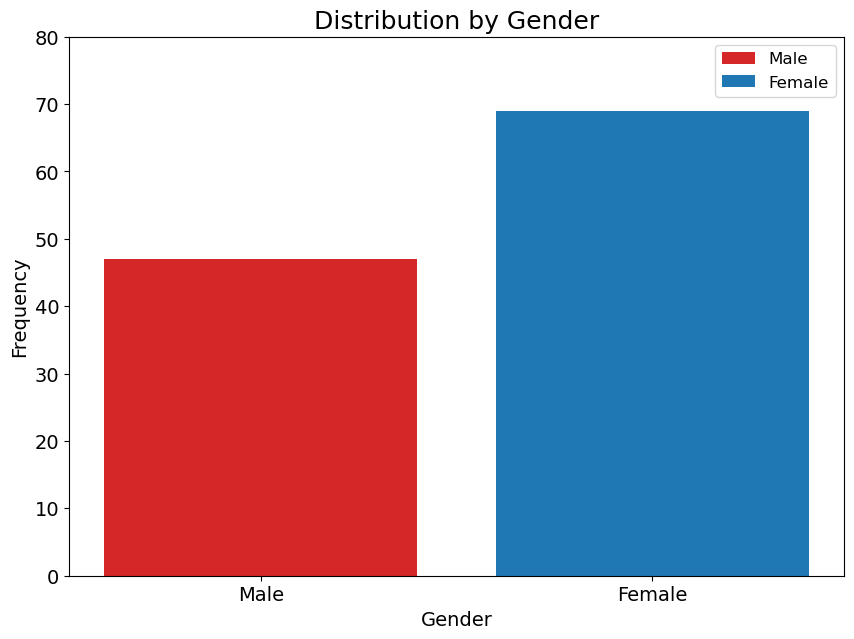

In [55]:
plot_barplot()

In [29]:
# Correlation matrix and confusion matrix

figures = cdf.iloc[:, 1:5]
gen_fig = cdf.iloc[:, [1, 2, 3, 4, 6]]
corr_matrix = figures.corr(method = "pearson")
corr_matrix

,age,annual_income,spending_score,total_amount
age,1.000000,0.231394,-0.389011,0.002005
annual_income,0.231394,1.000000,-0.198055,0.805400
spending_score,-0.389011,-0.198055,1.000000,0.382044
total_amount,0.002005,0.805400,0.382044,1.000000


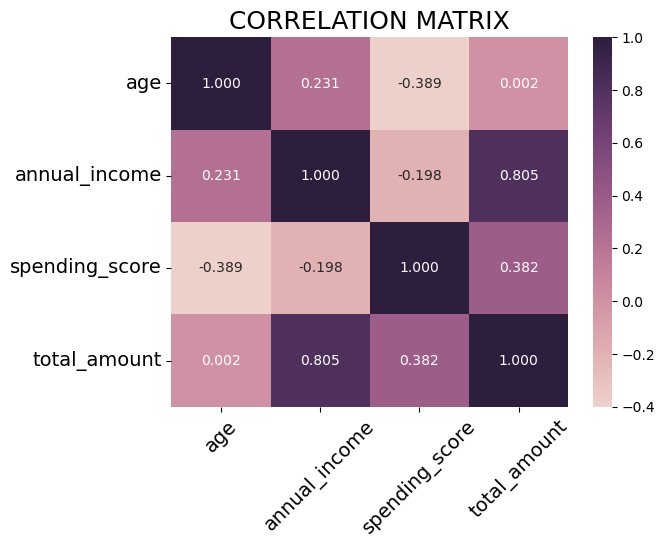

In [34]:
plot_heatmap(corr_matrix)

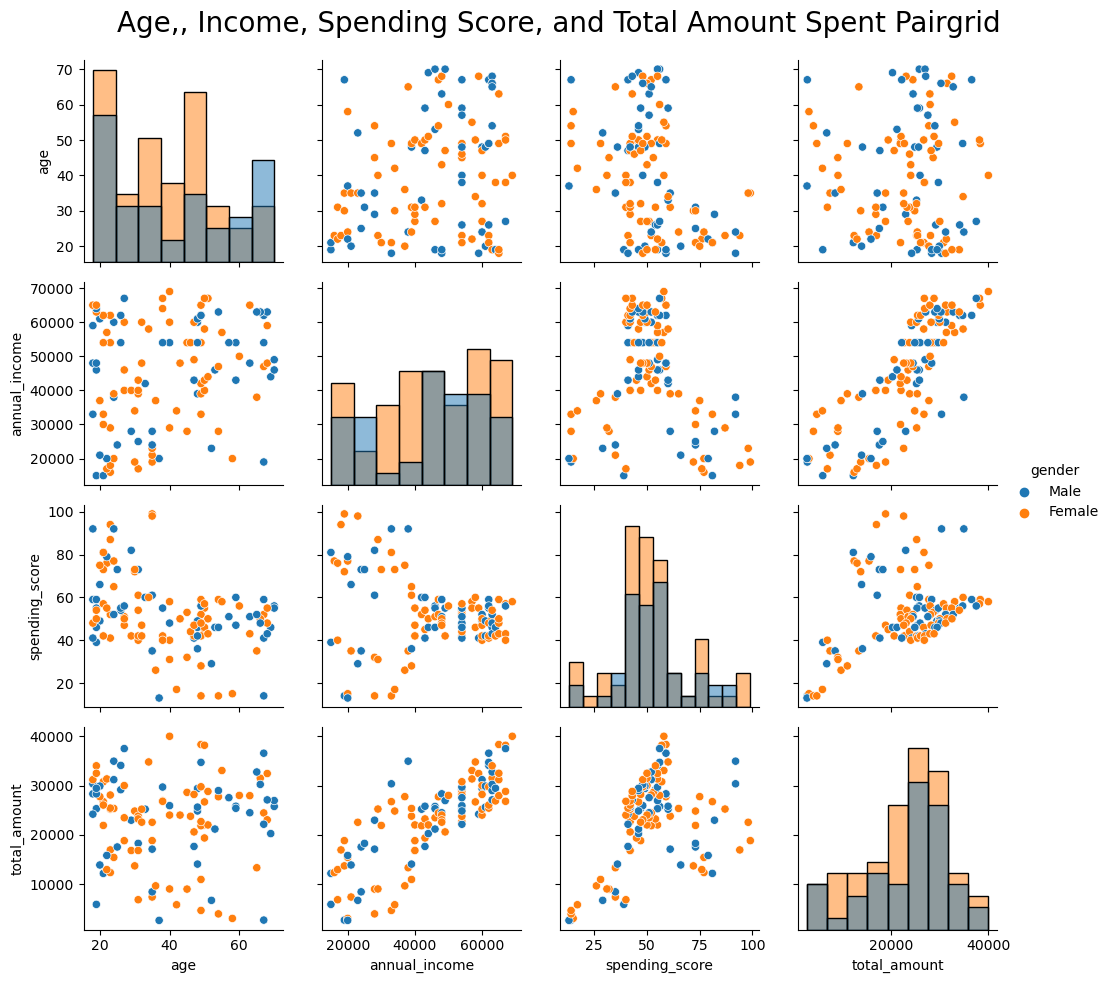

In [47]:
plot_pairplot()

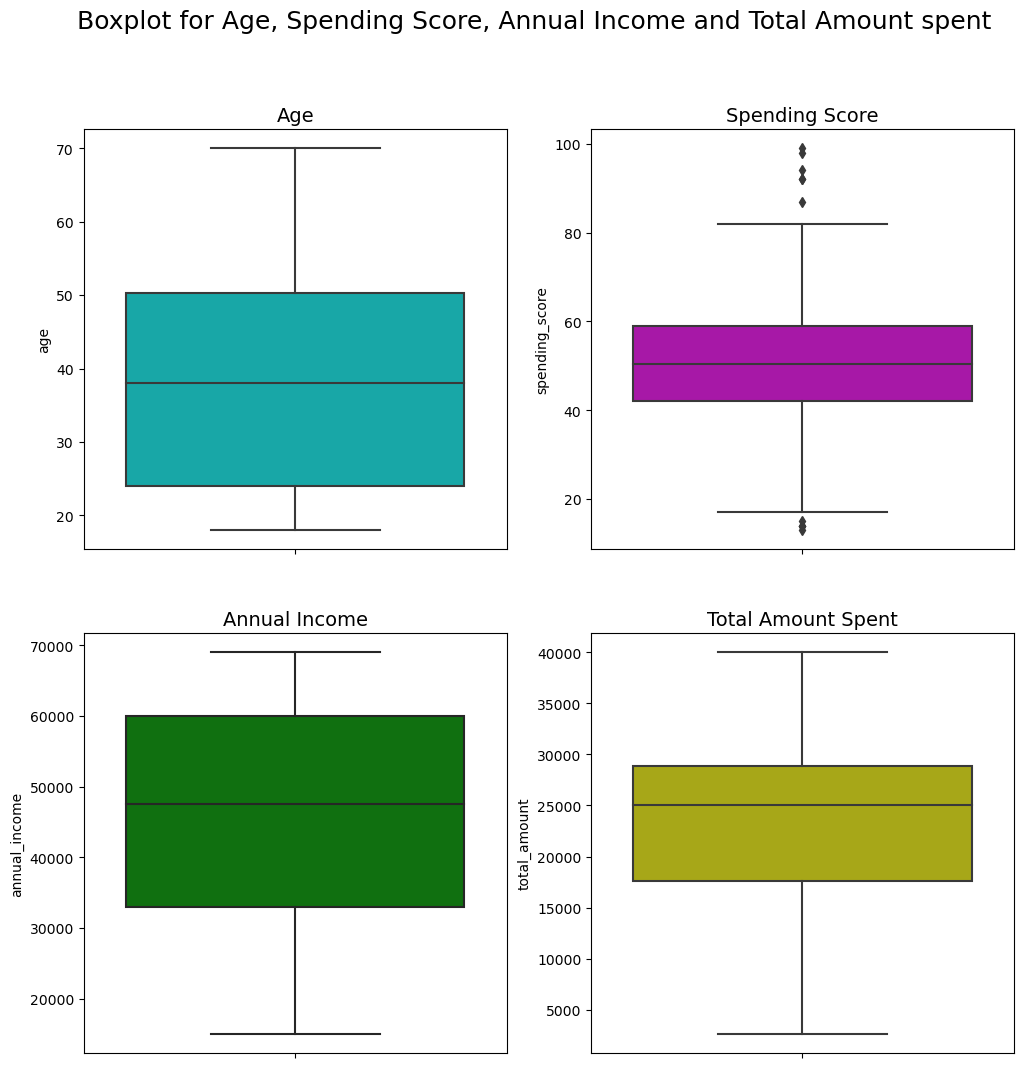

In [84]:
plot_boxplots()

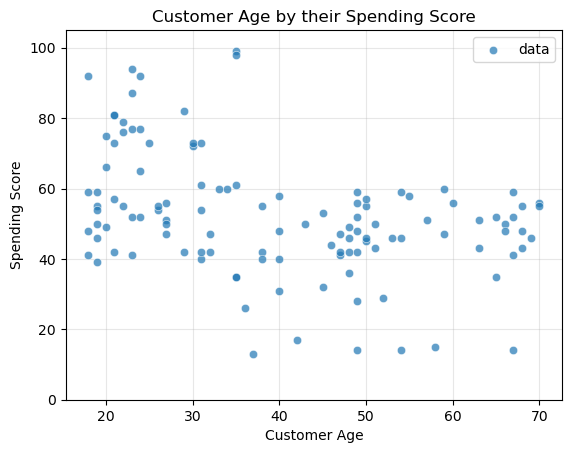

In [140]:
x = cdf["age"]
y = cdf["spending_score"]

plot_scatter(cdf, x, y, 0, 105, "Customer Age", 
             "Spending Score", "Customer Age by their Spending Score")

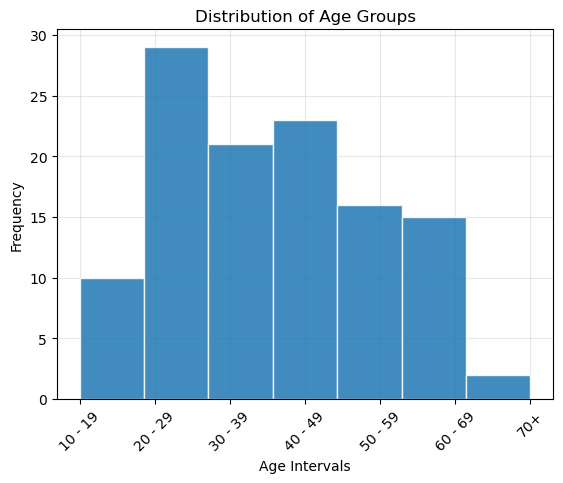

In [148]:
groups_label = cdf["age_group"].unique()

age_sorted = cdf.sort_values(by='age_group', ascending=True)

plot_age_hist(age_sorted, groups_label)

In [120]:
silhouette_score(xy, labels)

0.553931997444648

In [112]:
x = customer_df["Spending Score (1-100)"]
y = customer_df["Annual Income (k$)"]

In [121]:
best_n, best_score = None, -np.inf
for n in range(3, 9):  # 2 to 10 clusters
    score = one_silhoutte(n, xy)
    if score > best_score:
        best_n = n
        best_score = score
    print(f"{n:2g} clusters silhoutte score = {score:0.2f}")

print(f"Best number of clusters = {best_n:2g}")

C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 3 clusters silhoutte score = 0.47


C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 4 clusters silhoutte score = 0.49


C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 5 clusters silhoutte score = 0.55


C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 6 clusters silhoutte score = 0.54


C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 7 clusters silhoutte score = 0.53


C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 8 clusters silhoutte score = 0.46
Best number of clusters =  5


C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

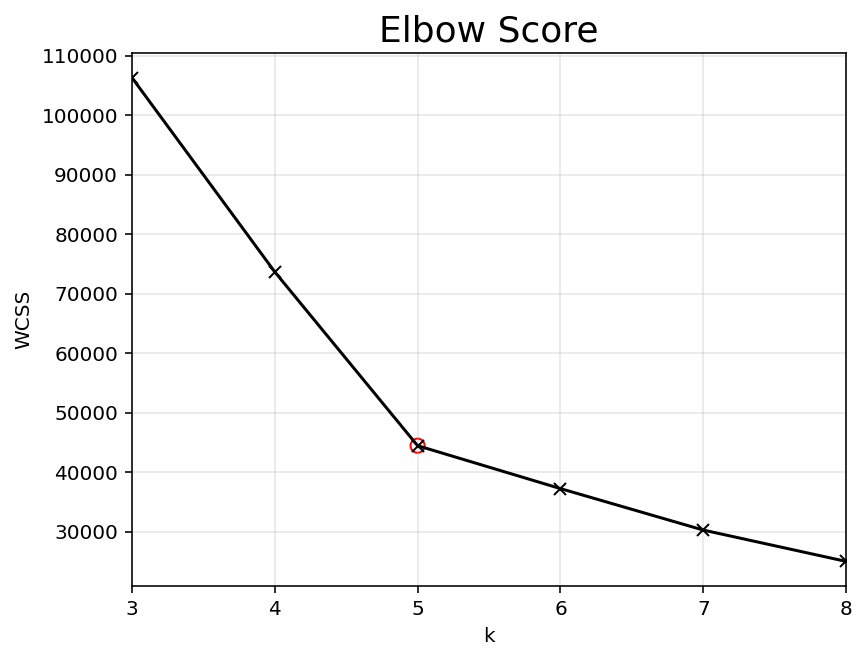

In [138]:
wcss = []
for n in range(3, 9):
    kmeans = KMeans(n_clusters = n, n_init = 20)
    kmeans.fit(xy)
    wcss.append(kmeans.inertia_)

plot_elbow_method(3, 8, wcss, best_n)

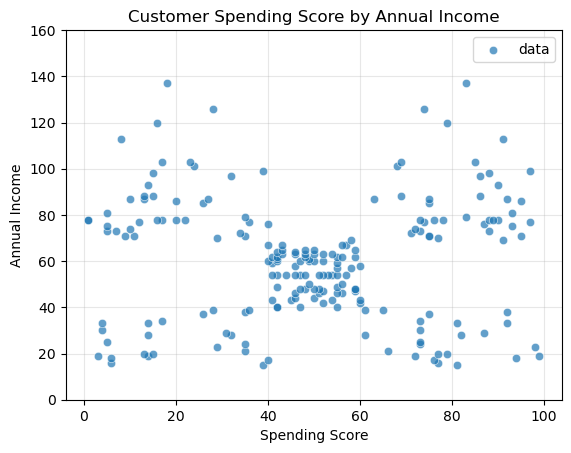

In [166]:
plot_scatter(customer_df, "Spending Score (1-100)", 
             "Annual Income (k$)", 0, 160, "Spending Score", 
             "Annual Income", "Customer Spending Score by Annual Income")

C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


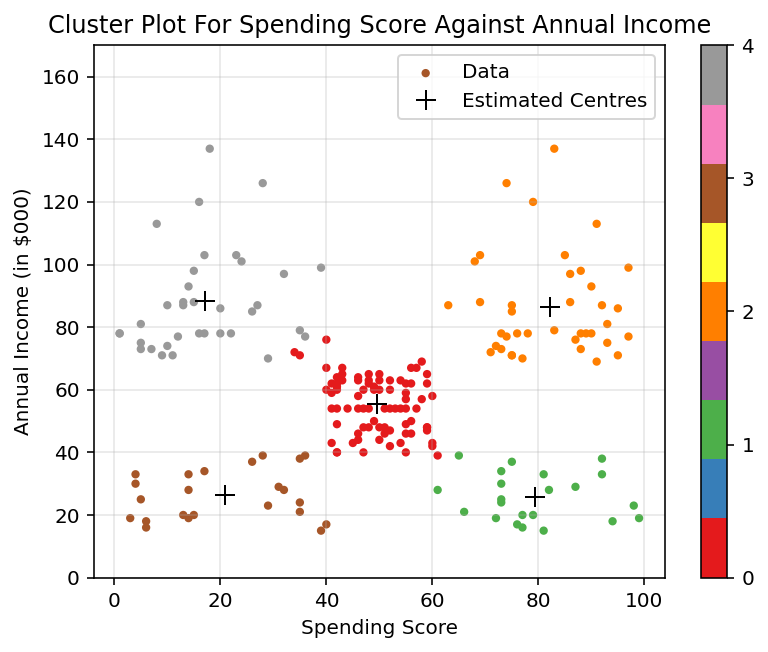

In [139]:
xy, xkmeans, ykmeans, labels = create_clusters(x, y)
plot_fitted_clusters(x, y, xkmeans, ykmeans, labels)

C:\anaconda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


a = 0.45 +/- 0.03
b = 2827.60 +/- 1473.99


a = 0.45 +/- 0.03
b = 2827.60 +/- 1473.99


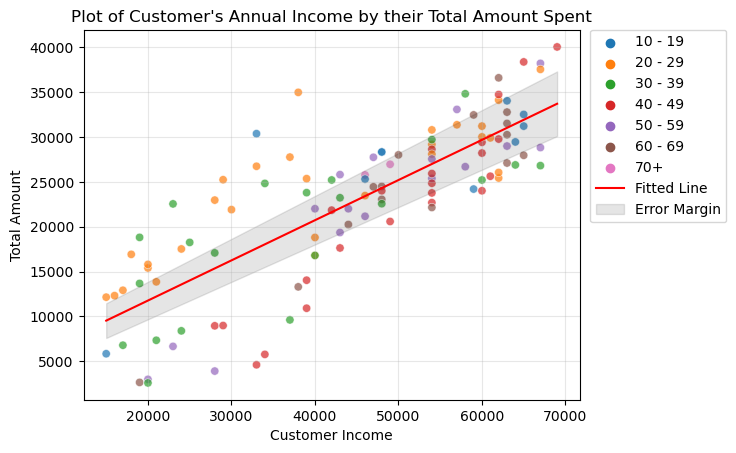

In [164]:
inc, spending, p, sigma = fitting()

plot_fit()